In [41]:
import torch
from torchvision import datasets, transforms

data_dir = 'CroppedYale'
batch_size = 30
#192, 168
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([30, 1, 32, 32])
torch.Size([30])


In [44]:
# visualize a batch of training data
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img,(1, 2, 0)))  # convert from Tensor image

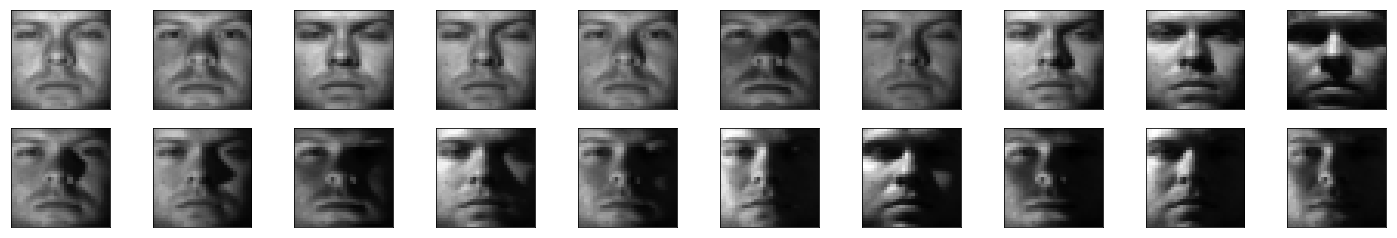

In [45]:
# obtain one batch of training images
import numpy as np

dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        
        # Fully connected layer
        self.fc1 = torch.nn.Linear(120, 84)
        self.fc2 = torch.nn.Linear(84, 40) 
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        x = self.max_pool_1(F.tanh(self.conv1(x)))
        x = self.max_pool_2(F.tanh(self.conv2(x)))
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.softmax(self.fc2(x))
        
        return x

In [8]:
from torch import nn, optim

model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

epochs = 1000
steps = 0

train_losses, test_losses, val_losses = [], [], []
for e in range(epochs):
    running_loss = 0
    train_accuracy = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        val_loss = 0
        test_accuracy = 0
        val_accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
            for images, labels in valloader:
                log_ps = model(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        val_losses.append(val_loss/len(valloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Training Accuracy: {:.3f}.. ".format(train_accuracy/len(trainloader)),
              "Validation Loss: {:.3f}.. ".format(val_loss/len(valloader)),
              "Validation Accuracy: {:.3f}".format(val_accuracy/len(valloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(test_accuracy/len(testloader)))

/home/fm-lt-118/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 1/1000..  Training Loss: 3.689..  Training Accuracy: 0.019..  Validation Loss: 3.689..  Validation Accuracy: 0.014 Test Loss: 3.689..  Test Accuracy: 0.024
Epoch: 2/1000..  Training Loss: 3.689..  Training Accuracy: 0.018..  Validation Loss: 3.689..  Validation Accuracy: 0.014 Test Loss: 3.689..  Test Accuracy: 0.019
Epoch: 3/1000..  Training Loss: 3.689..  Training Accuracy: 0.015..  Validation Loss: 3.689..  Validation Accuracy: 0.014 Test Loss: 3.689..  Test Accuracy: 0.043
Epoch: 4/1000..  Training Loss: 3.689..  Training Accuracy: 0.016..  Validation Loss: 3.689..  Validation Accuracy: 0.029 Test Loss: 3.689..  Test Accuracy: 0.043
Epoch: 5/1000..  Training Loss: 3.689..  Training Accuracy: 0.032..  Validation Loss: 3.688..  Validation Accuracy: 0.067 Test Loss: 3.688..  Test Accuracy: 0.071
Epoch: 6/1000..  Training Loss: 3.689..  Training Accuracy: 0.034..  Validation Loss: 3.688..  Validation Accuracy: 0.076 Test Loss: 3.688..  Test Accuracy: 0.076
Epoch: 7/1000..  Train

Epoch: 52/1000..  Training Loss: 3.684..  Training Accuracy: 0.043..  Validation Loss: 3.669..  Validation Accuracy: 0.081 Test Loss: 3.667..  Test Accuracy: 0.076
Epoch: 53/1000..  Training Loss: 3.684..  Training Accuracy: 0.043..  Validation Loss: 3.670..  Validation Accuracy: 0.086 Test Loss: 3.668..  Test Accuracy: 0.076
Epoch: 54/1000..  Training Loss: 3.684..  Training Accuracy: 0.042..  Validation Loss: 3.671..  Validation Accuracy: 0.086 Test Loss: 3.669..  Test Accuracy: 0.076
Epoch: 55/1000..  Training Loss: 3.684..  Training Accuracy: 0.042..  Validation Loss: 3.672..  Validation Accuracy: 0.095 Test Loss: 3.670..  Test Accuracy: 0.076
Epoch: 56/1000..  Training Loss: 3.683..  Training Accuracy: 0.042..  Validation Loss: 3.673..  Validation Accuracy: 0.090 Test Loss: 3.670..  Test Accuracy: 0.081
Epoch: 57/1000..  Training Loss: 3.683..  Training Accuracy: 0.042..  Validation Loss: 3.674..  Validation Accuracy: 0.081 Test Loss: 3.671..  Test Accuracy: 0.086
Epoch: 58/1000..

Epoch: 102/1000..  Training Loss: 3.657..  Training Accuracy: 0.060..  Validation Loss: 3.624..  Validation Accuracy: 0.090 Test Loss: 3.621..  Test Accuracy: 0.100
Epoch: 103/1000..  Training Loss: 3.656..  Training Accuracy: 0.061..  Validation Loss: 3.624..  Validation Accuracy: 0.095 Test Loss: 3.622..  Test Accuracy: 0.095
Epoch: 104/1000..  Training Loss: 3.655..  Training Accuracy: 0.060..  Validation Loss: 3.625..  Validation Accuracy: 0.090 Test Loss: 3.622..  Test Accuracy: 0.095
Epoch: 105/1000..  Training Loss: 3.654..  Training Accuracy: 0.059..  Validation Loss: 3.625..  Validation Accuracy: 0.095 Test Loss: 3.622..  Test Accuracy: 0.095
Epoch: 106/1000..  Training Loss: 3.653..  Training Accuracy: 0.060..  Validation Loss: 3.624..  Validation Accuracy: 0.100 Test Loss: 3.621..  Test Accuracy: 0.095
Epoch: 107/1000..  Training Loss: 3.652..  Training Accuracy: 0.061..  Validation Loss: 3.623..  Validation Accuracy: 0.095 Test Loss: 3.621..  Test Accuracy: 0.095
Epoch: 108

Epoch: 152/1000..  Training Loss: 3.586..  Training Accuracy: 0.158..  Validation Loss: 3.535..  Validation Accuracy: 0.190 Test Loss: 3.542..  Test Accuracy: 0.176
Epoch: 153/1000..  Training Loss: 3.581..  Training Accuracy: 0.156..  Validation Loss: 3.538..  Validation Accuracy: 0.176 Test Loss: 3.542..  Test Accuracy: 0.176
Epoch: 154/1000..  Training Loss: 3.578..  Training Accuracy: 0.160..  Validation Loss: 3.532..  Validation Accuracy: 0.190 Test Loss: 3.539..  Test Accuracy: 0.186
Epoch: 155/1000..  Training Loss: 3.576..  Training Accuracy: 0.161..  Validation Loss: 3.545..  Validation Accuracy: 0.176 Test Loss: 3.551..  Test Accuracy: 0.171
Epoch: 156/1000..  Training Loss: 3.577..  Training Accuracy: 0.157..  Validation Loss: 3.530..  Validation Accuracy: 0.190 Test Loss: 3.541..  Test Accuracy: 0.186
Epoch: 157/1000..  Training Loss: 3.576..  Training Accuracy: 0.161..  Validation Loss: 3.534..  Validation Accuracy: 0.181 Test Loss: 3.546..  Test Accuracy: 0.171
Epoch: 158

Epoch: 202/1000..  Training Loss: 3.391..  Training Accuracy: 0.351..  Validation Loss: 3.333..  Validation Accuracy: 0.410 Test Loss: 3.367..  Test Accuracy: 0.376
Epoch: 203/1000..  Training Loss: 3.387..  Training Accuracy: 0.357..  Validation Loss: 3.337..  Validation Accuracy: 0.400 Test Loss: 3.370..  Test Accuracy: 0.362
Epoch: 204/1000..  Training Loss: 3.385..  Training Accuracy: 0.360..  Validation Loss: 3.340..  Validation Accuracy: 0.405 Test Loss: 3.373..  Test Accuracy: 0.362
Epoch: 205/1000..  Training Loss: 3.383..  Training Accuracy: 0.362..  Validation Loss: 3.339..  Validation Accuracy: 0.405 Test Loss: 3.376..  Test Accuracy: 0.362
Epoch: 206/1000..  Training Loss: 3.381..  Training Accuracy: 0.363..  Validation Loss: 3.337..  Validation Accuracy: 0.405 Test Loss: 3.377..  Test Accuracy: 0.362
Epoch: 207/1000..  Training Loss: 3.379..  Training Accuracy: 0.365..  Validation Loss: 3.343..  Validation Accuracy: 0.400 Test Loss: 3.384..  Test Accuracy: 0.362
Epoch: 208

Epoch: 252/1000..  Training Loss: 3.339..  Training Accuracy: 0.391..  Validation Loss: 3.280..  Validation Accuracy: 0.448 Test Loss: 3.315..  Test Accuracy: 0.419
Epoch: 253/1000..  Training Loss: 3.338..  Training Accuracy: 0.391..  Validation Loss: 3.280..  Validation Accuracy: 0.448 Test Loss: 3.314..  Test Accuracy: 0.419
Epoch: 254/1000..  Training Loss: 3.338..  Training Accuracy: 0.391..  Validation Loss: 3.280..  Validation Accuracy: 0.448 Test Loss: 3.313..  Test Accuracy: 0.419
Epoch: 255/1000..  Training Loss: 3.338..  Training Accuracy: 0.391..  Validation Loss: 3.280..  Validation Accuracy: 0.448 Test Loss: 3.312..  Test Accuracy: 0.419
Epoch: 256/1000..  Training Loss: 3.337..  Training Accuracy: 0.391..  Validation Loss: 3.280..  Validation Accuracy: 0.452 Test Loss: 3.311..  Test Accuracy: 0.419
Epoch: 257/1000..  Training Loss: 3.337..  Training Accuracy: 0.391..  Validation Loss: 3.280..  Validation Accuracy: 0.452 Test Loss: 3.309..  Test Accuracy: 0.424
Epoch: 258

Epoch: 302/1000..  Training Loss: 3.293..  Training Accuracy: 0.442..  Validation Loss: 3.254..  Validation Accuracy: 0.481 Test Loss: 3.276..  Test Accuracy: 0.467
Epoch: 303/1000..  Training Loss: 3.291..  Training Accuracy: 0.445..  Validation Loss: 3.253..  Validation Accuracy: 0.481 Test Loss: 3.276..  Test Accuracy: 0.467
Epoch: 304/1000..  Training Loss: 3.290..  Training Accuracy: 0.446..  Validation Loss: 3.249..  Validation Accuracy: 0.481 Test Loss: 3.274..  Test Accuracy: 0.467
Epoch: 305/1000..  Training Loss: 3.288..  Training Accuracy: 0.446..  Validation Loss: 3.245..  Validation Accuracy: 0.490 Test Loss: 3.273..  Test Accuracy: 0.467
Epoch: 306/1000..  Training Loss: 3.286..  Training Accuracy: 0.446..  Validation Loss: 3.243..  Validation Accuracy: 0.495 Test Loss: 3.275..  Test Accuracy: 0.462
Epoch: 307/1000..  Training Loss: 3.286..  Training Accuracy: 0.447..  Validation Loss: 3.240..  Validation Accuracy: 0.495 Test Loss: 3.275..  Test Accuracy: 0.462
Epoch: 308

Epoch: 352/1000..  Training Loss: 3.230..  Training Accuracy: 0.500..  Validation Loss: 3.190..  Validation Accuracy: 0.548 Test Loss: 3.241..  Test Accuracy: 0.486
Epoch: 353/1000..  Training Loss: 3.229..  Training Accuracy: 0.503..  Validation Loss: 3.187..  Validation Accuracy: 0.552 Test Loss: 3.236..  Test Accuracy: 0.495
Epoch: 354/1000..  Training Loss: 3.226..  Training Accuracy: 0.509..  Validation Loss: 3.182..  Validation Accuracy: 0.562 Test Loss: 3.231..  Test Accuracy: 0.495
Epoch: 355/1000..  Training Loss: 3.223..  Training Accuracy: 0.515..  Validation Loss: 3.178..  Validation Accuracy: 0.567 Test Loss: 3.227..  Test Accuracy: 0.495
Epoch: 356/1000..  Training Loss: 3.219..  Training Accuracy: 0.518..  Validation Loss: 3.176..  Validation Accuracy: 0.562 Test Loss: 3.226..  Test Accuracy: 0.495
Epoch: 357/1000..  Training Loss: 3.216..  Training Accuracy: 0.520..  Validation Loss: 3.174..  Validation Accuracy: 0.562 Test Loss: 3.224..  Test Accuracy: 0.500
Epoch: 358

Epoch: 402/1000..  Training Loss: 3.151..  Training Accuracy: 0.577..  Validation Loss: 3.116..  Validation Accuracy: 0.614 Test Loss: 3.165..  Test Accuracy: 0.571
Epoch: 403/1000..  Training Loss: 3.151..  Training Accuracy: 0.578..  Validation Loss: 3.115..  Validation Accuracy: 0.614 Test Loss: 3.164..  Test Accuracy: 0.571
Epoch: 404/1000..  Training Loss: 3.149..  Training Accuracy: 0.581..  Validation Loss: 3.112..  Validation Accuracy: 0.619 Test Loss: 3.161..  Test Accuracy: 0.576
Epoch: 405/1000..  Training Loss: 3.147..  Training Accuracy: 0.587..  Validation Loss: 3.105..  Validation Accuracy: 0.633 Test Loss: 3.156..  Test Accuracy: 0.586
Epoch: 406/1000..  Training Loss: 3.143..  Training Accuracy: 0.594..  Validation Loss: 3.099..  Validation Accuracy: 0.633 Test Loss: 3.154..  Test Accuracy: 0.590
Epoch: 407/1000..  Training Loss: 3.139..  Training Accuracy: 0.599..  Validation Loss: 3.097..  Validation Accuracy: 0.633 Test Loss: 3.154..  Test Accuracy: 0.581
Epoch: 408

Epoch: 452/1000..  Training Loss: 3.079..  Training Accuracy: 0.651..  Validation Loss: 3.046..  Validation Accuracy: 0.686 Test Loss: 3.106..  Test Accuracy: 0.633
Epoch: 453/1000..  Training Loss: 3.079..  Training Accuracy: 0.651..  Validation Loss: 3.046..  Validation Accuracy: 0.686 Test Loss: 3.105..  Test Accuracy: 0.633
Epoch: 454/1000..  Training Loss: 3.079..  Training Accuracy: 0.651..  Validation Loss: 3.046..  Validation Accuracy: 0.686 Test Loss: 3.105..  Test Accuracy: 0.633
Epoch: 455/1000..  Training Loss: 3.079..  Training Accuracy: 0.653..  Validation Loss: 3.047..  Validation Accuracy: 0.686 Test Loss: 3.106..  Test Accuracy: 0.629
Epoch: 456/1000..  Training Loss: 3.079..  Training Accuracy: 0.653..  Validation Loss: 3.047..  Validation Accuracy: 0.686 Test Loss: 3.109..  Test Accuracy: 0.624
Epoch: 457/1000..  Training Loss: 3.078..  Training Accuracy: 0.653..  Validation Loss: 3.046..  Validation Accuracy: 0.686 Test Loss: 3.109..  Test Accuracy: 0.629
Epoch: 458

Epoch: 502/1000..  Training Loss: 3.050..  Training Accuracy: 0.681..  Validation Loss: 3.024..  Validation Accuracy: 0.710 Test Loss: 3.079..  Test Accuracy: 0.652
Epoch: 503/1000..  Training Loss: 3.050..  Training Accuracy: 0.681..  Validation Loss: 3.024..  Validation Accuracy: 0.710 Test Loss: 3.078..  Test Accuracy: 0.662
Epoch: 504/1000..  Training Loss: 3.050..  Training Accuracy: 0.681..  Validation Loss: 3.024..  Validation Accuracy: 0.710 Test Loss: 3.078..  Test Accuracy: 0.662
Epoch: 505/1000..  Training Loss: 3.050..  Training Accuracy: 0.681..  Validation Loss: 3.024..  Validation Accuracy: 0.710 Test Loss: 3.077..  Test Accuracy: 0.662
Epoch: 506/1000..  Training Loss: 3.050..  Training Accuracy: 0.681..  Validation Loss: 3.023..  Validation Accuracy: 0.710 Test Loss: 3.076..  Test Accuracy: 0.662
Epoch: 507/1000..  Training Loss: 3.050..  Training Accuracy: 0.681..  Validation Loss: 3.023..  Validation Accuracy: 0.710 Test Loss: 3.075..  Test Accuracy: 0.662
Epoch: 508

Epoch: 552/1000..  Training Loss: 3.047..  Training Accuracy: 0.681..  Validation Loss: 3.021..  Validation Accuracy: 0.710 Test Loss: 3.073..  Test Accuracy: 0.662
Epoch: 553/1000..  Training Loss: 3.047..  Training Accuracy: 0.681..  Validation Loss: 3.021..  Validation Accuracy: 0.710 Test Loss: 3.073..  Test Accuracy: 0.662
Epoch: 554/1000..  Training Loss: 3.047..  Training Accuracy: 0.681..  Validation Loss: 3.021..  Validation Accuracy: 0.710 Test Loss: 3.073..  Test Accuracy: 0.662
Epoch: 555/1000..  Training Loss: 3.047..  Training Accuracy: 0.681..  Validation Loss: 3.021..  Validation Accuracy: 0.710 Test Loss: 3.073..  Test Accuracy: 0.662
Epoch: 556/1000..  Training Loss: 3.047..  Training Accuracy: 0.681..  Validation Loss: 3.021..  Validation Accuracy: 0.710 Test Loss: 3.073..  Test Accuracy: 0.662
Epoch: 557/1000..  Training Loss: 3.047..  Training Accuracy: 0.681..  Validation Loss: 3.021..  Validation Accuracy: 0.710 Test Loss: 3.073..  Test Accuracy: 0.662
Epoch: 558

Epoch: 602/1000..  Training Loss: 3.024..  Training Accuracy: 0.706..  Validation Loss: 3.005..  Validation Accuracy: 0.729 Test Loss: 3.046..  Test Accuracy: 0.700
Epoch: 603/1000..  Training Loss: 3.024..  Training Accuracy: 0.706..  Validation Loss: 3.005..  Validation Accuracy: 0.729 Test Loss: 3.046..  Test Accuracy: 0.700
Epoch: 604/1000..  Training Loss: 3.023..  Training Accuracy: 0.706..  Validation Loss: 3.004..  Validation Accuracy: 0.729 Test Loss: 3.046..  Test Accuracy: 0.700
Epoch: 605/1000..  Training Loss: 3.023..  Training Accuracy: 0.706..  Validation Loss: 3.004..  Validation Accuracy: 0.729 Test Loss: 3.045..  Test Accuracy: 0.695
Epoch: 606/1000..  Training Loss: 3.023..  Training Accuracy: 0.706..  Validation Loss: 3.004..  Validation Accuracy: 0.729 Test Loss: 3.045..  Test Accuracy: 0.695
Epoch: 607/1000..  Training Loss: 3.023..  Training Accuracy: 0.706..  Validation Loss: 3.004..  Validation Accuracy: 0.729 Test Loss: 3.045..  Test Accuracy: 0.695
Epoch: 608

Epoch: 652/1000..  Training Loss: 2.998..  Training Accuracy: 0.732..  Validation Loss: 2.981..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.710
Epoch: 653/1000..  Training Loss: 2.998..  Training Accuracy: 0.732..  Validation Loss: 2.981..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.710
Epoch: 654/1000..  Training Loss: 2.998..  Training Accuracy: 0.732..  Validation Loss: 2.981..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 655/1000..  Training Loss: 2.998..  Training Accuracy: 0.732..  Validation Loss: 2.981..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 656/1000..  Training Loss: 2.998..  Training Accuracy: 0.732..  Validation Loss: 2.981..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.710
Epoch: 657/1000..  Training Loss: 2.998..  Training Accuracy: 0.732..  Validation Loss: 2.981..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.710
Epoch: 658

Epoch: 702/1000..  Training Loss: 2.996..  Training Accuracy: 0.733..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 703/1000..  Training Loss: 2.996..  Training Accuracy: 0.733..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 704/1000..  Training Loss: 2.996..  Training Accuracy: 0.733..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 705/1000..  Training Loss: 2.996..  Training Accuracy: 0.733..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 706/1000..  Training Loss: 2.996..  Training Accuracy: 0.733..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 707/1000..  Training Loss: 2.996..  Training Accuracy: 0.733..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 708

Epoch: 752/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.980..  Validation Accuracy: 0.752 Test Loss: 3.027..  Test Accuracy: 0.700
Epoch: 753/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.980..  Validation Accuracy: 0.752 Test Loss: 3.027..  Test Accuracy: 0.700
Epoch: 754/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.980..  Validation Accuracy: 0.752 Test Loss: 3.027..  Test Accuracy: 0.700
Epoch: 755/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.980..  Validation Accuracy: 0.752 Test Loss: 3.027..  Test Accuracy: 0.700
Epoch: 756/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.980..  Validation Accuracy: 0.752 Test Loss: 3.027..  Test Accuracy: 0.700
Epoch: 757/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.980..  Validation Accuracy: 0.752 Test Loss: 3.027..  Test Accuracy: 0.700
Epoch: 758

Epoch: 802/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.748 Test Loss: 3.026..  Test Accuracy: 0.700
Epoch: 803/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.748 Test Loss: 3.026..  Test Accuracy: 0.700
Epoch: 804/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.748 Test Loss: 3.026..  Test Accuracy: 0.700
Epoch: 805/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.748 Test Loss: 3.026..  Test Accuracy: 0.700
Epoch: 806/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.748 Test Loss: 3.026..  Test Accuracy: 0.700
Epoch: 807/1000..  Training Loss: 2.995..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.748 Test Loss: 3.026..  Test Accuracy: 0.700
Epoch: 808

Epoch: 852/1000..  Training Loss: 2.994..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 853/1000..  Training Loss: 2.994..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 854/1000..  Training Loss: 2.994..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 855/1000..  Training Loss: 2.994..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 856/1000..  Training Loss: 2.994..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 857/1000..  Training Loss: 2.994..  Training Accuracy: 0.734..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.025..  Test Accuracy: 0.719
Epoch: 858

Epoch: 902/1000..  Training Loss: 2.994..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 903/1000..  Training Loss: 2.994..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 904/1000..  Training Loss: 2.994..  Training Accuracy: 0.735..  Validation Loss: 2.978..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 905/1000..  Training Loss: 2.994..  Training Accuracy: 0.735..  Validation Loss: 2.978..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 906/1000..  Training Loss: 2.994..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 907/1000..  Training Loss: 2.994..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.026..  Test Accuracy: 0.714
Epoch: 908

Epoch: 952/1000..  Training Loss: 2.993..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.024..  Test Accuracy: 0.714
Epoch: 953/1000..  Training Loss: 2.993..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.024..  Test Accuracy: 0.714
Epoch: 954/1000..  Training Loss: 2.993..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.024..  Test Accuracy: 0.714
Epoch: 955/1000..  Training Loss: 2.993..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.024..  Test Accuracy: 0.714
Epoch: 956/1000..  Training Loss: 2.993..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.024..  Test Accuracy: 0.714
Epoch: 957/1000..  Training Loss: 2.993..  Training Accuracy: 0.735..  Validation Loss: 2.979..  Validation Accuracy: 0.752 Test Loss: 3.024..  Test Accuracy: 0.714
Epoch: 958

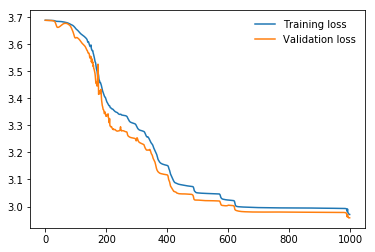

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

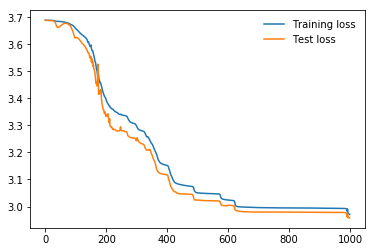

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Test loss')
plt.legend(frameon=False)